# Segmentation Workflow

The purpose of this jupyter notebook is to perform pre-processing, segmentation, and labeling of segmented ROIs.  

**Preprocessing** steps convert the image to grayscale and performs unsharp masking to remove varied background fluorescence.

**Segmentation** takes place using watershed transform



First we need to import the important packages we will use and mount the notebook to drive. This notebook uses `skimage` for image processing and thte `pyplot` module of `matplotlib` for image visualization



In [ ]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os

# mount drive- following tutorial at https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674
from google.colab import drive
drive.mount('/content/drive')
 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next we need to load the image and convert it into grayscale

(512, 512)


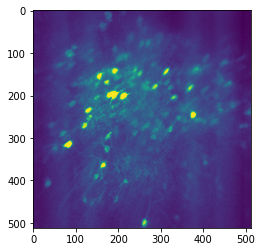

In [ ]:
from skimage.util import img_as_ubyte, img_as_float

im_dir='drive/My Drive/CHEME 599/Project/images'; # image path to open

fname='PL01_day3.jpg'
im=plt.imread(os.path.join(im_dir, fname)); # read image 
from skimage import color
im=color.rgb2gray(im) 
print(im.shape)
plt.imshow(im)
im=img_as_ubyte(img_as_float(im))

The major preprocessing step we will use is unsharp masking which is used to remove large fluctuations in background intensity across an image. This makes it much easier to differentiate neurons from general background fluorescence from neuropil


In [ ]:
def unsharp_mask(im, scale):  
    from skimage.morphology import square
    from skimage.filters import rank
    from skimage.util import img_as_ubyte

    im=img_as_ubyte(im) # ensure the image is in uint8 form
    length=int((np.round(im.shape[1]/scale,0))); # set filter size to 1/ scaling factor of image size 
    selem=square(length) # create mask that is half as wide as the image rounded up
    background=1.0*rank.mean(im, selem) # generate the background image
    im_us=im-background # subtract background from main image
  # normalize the image fluoresence
    im_min=np.min(im_us)
    im_range = np.max(im_us)-im_min
    im_us = np.round(255*(im_us - im_min)/im_range, 0) # normalize
    return(im_us)

It is time to perform unsharp masking on the image. Note how much clearer cells are on the produced unsharp masked image

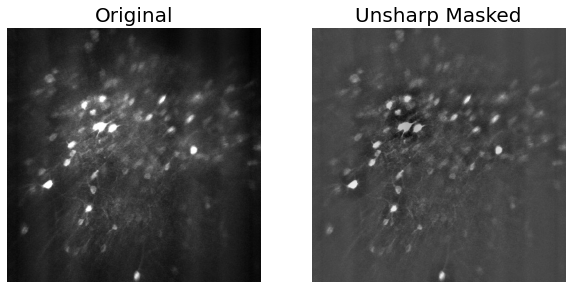

In [ ]:
#from skimage.exposure import equalize_hist

im_us=unsharp_mask(im,10)

fig, ax = plt.subplots(ncols=2, figsize=(10,6)) 
titles=('Original', 'Unsharp Masked')
for axi, title in zip(ax,titles):
  axi.axis('off')
  axi.set_title(title, fontsize=20)

ax[0].imshow(im, cmap='gray')
ax[1].imshow(im_us, cmap='gray');

Now it is time to segment the neurons!
We need to import some functions to do this

In [ ]:
from skimage.feature import canny # smooths image before calculating edges, can remove false edges
from skimage.morphology import disk, binary_dilation, binary_erosion
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects

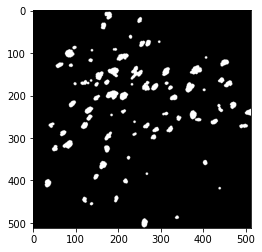

In [ ]:
im5=img_as_float(im_us>80)
from skimage.morphology import binary_opening
im3=binary_opening(im5, disk(3))

plt.imshow(im3, cmap='gray')

(-0.5, 511.5, 511.5, -0.5)

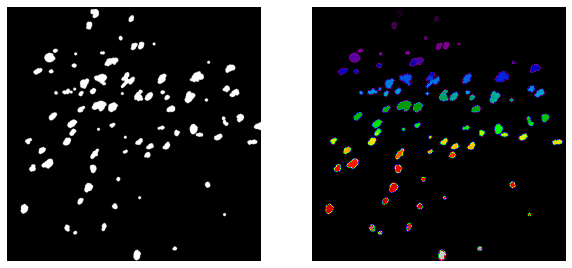

In [ ]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

distance = ndimage.distance_transform_edt(im3)#
#local_maxi = is_local_maximum(distance, image, np.ones((3, 3)))
#markers = ndimage.label(local_maxi)[0]
#labels = watershed(-distance, markers, mask=image)
localMax = peak_local_max(distance, indices=False, min_distance=8)
markers = ndimage.label(localMax)[0]
labels = watershed(-distance, markers, mask=im3)


fig, axes=plt.subplots(ncols=2, figsize=(10,6))
axes[0].imshow(im3, cmap='gray')
axes[1].imshow(labels,cmap='nipy_spectral') 
axes[0].axis('off')
axes[1].axis('off')

(-0.5, 511.5, 511.5, -0.5)

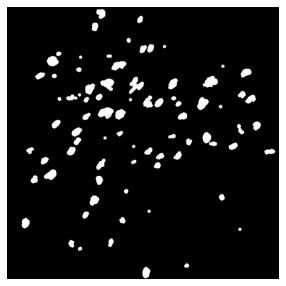

In [ ]:
from skimage.morphology import binary_opening
labels=labels>0;
im4=binary_opening(labels, disk(3))
fig, axes=plt.subplots(ncols=1, figsize=(5,5))
axes.imshow(im4, cmap='gray')
axes.axis('off')

(-0.5, 511.5, 511.5, -0.5)

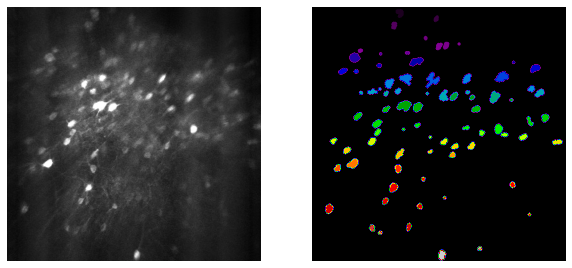

In [ ]:
from scipy.ndimage import label
from skimage.color import label2rgb

labeled2, _ = label(im4)

fig, axes=plt.subplots(ncols=2, figsize=(10,6))
axes[0].imshow(im, cmap='gray')
axes[1].imshow(labeled2,cmap='nipy_spectral') 
axes[0].axis('off')
axes[1].axis('off')
